# Allan-save
Calculates Allan and Hadamard deviations from sorted Orbitrap data.

### Inputs:
- Path to sorted data files and the ending of the file to be analysed
- Plots = True or False, whether to generate plots or not

### Outputs: 
- Calculates Allan deviation and Hadamard deviation. Saves them (tau,dev,deverr,n_eff) in the folder 'Allan_variance'
- A mean n_eff is calculated for each isotopologue using $ n_{eff} = \frac{n_{basepeak}n_{peak}}{n_{basepeak}+n_{peak}}$

## Specify inputs

In [98]:
import pandas as pd
import numpy as np
import allantools
import matplotlib.pyplot as plt
import os

# Inputs
path = 'data_sorted'
suffix = '_sorted_noM0.csv'
plots = True

## Calculation

In [99]:
files = [fn for fn in os.listdir(path) if fn.endswith(suffix)]

# Check the folder doesn't already exist
folder_path = 'Allan_variance'
if not os.path.exists(folder_path):
    try:
        # Create the folder
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully")
    except OSError as e:
        print(f"Error creating folder: {e}")
else:
    print(f"Folder '{folder_path}' already exists")

MIF_cols = {'NO3_M0':['D17O'],
            'NO3_noM0':['D17O'],
            'SO4_M0':['D17O','D33S'],
            'SO4_noM0':['D17O','D33S','D36S']}

for file in files:

    df = pd.read_csv(os.path.join(path,file))
    expt = df.loc[0,'experiment']
    columns = [col for col in df.columns if col.startswith('Ratio')]+list(MIF_cols[expt])
    save_adata=pd.DataFrame(index=range(0,1000))
    save_hdata=pd.DataFrame(index=range(0,1000))
    save_spectrum=pd.DataFrame(index=range(0,1000))

    if expt=='NO3_noM0':
        basepeak_ions = df['ions_15N']
    if expt=='SO4_noM0':
        basepeak_ions = df['ions_34S']
    if expt=='NO3_M0':
        basepeak_ions = df['ions_M0']
    if expt=='SO4_M0':
        basepeak_ions = df['ions_M0']
        
    for col in columns:
        if col.startswith('Ratio'):

            time_values = df.dropna()['time.min'].to_numpy()
            ratio_values = df.dropna()[col].to_numpy()
            ratio_pm = 1000*(ratio_values/np.mean(ratio_values)-1)

            # Generate a uniformly spaced time series using linear interpolation
            uniform_time, step = np.linspace(time_values[0], time_values[-1], num=len(df), retstep=True)  
            interp_pm = np.interp(uniform_time, time_values, ratio_pm)

            # Calculate the Allan variance using allantools
            atau, adev, adeverr, _ = allantools.oadev(interp_pm, rate=1/(60*step), data_type='freq',
                                               taus=np.logspace(np.log10(step*60),np.log10(step*60*len(df)),num=100))
            htau, hdev, hdeverr, _ = allantools.ohdev(interp_pm, rate=1/(60*step), data_type='freq',
                                               taus=np.logspace(np.log10(step*60),np.log10(step*60*len(df)),num=100))

            # counting statistics (shot noise limit)
            peak_ions = basepeak_ions * df[col]
            n_eff = basepeak_ions*peak_ions/(basepeak_ions+peak_ions)

            # put into DataFrame with suffixes for each isotope
            adata = pd.DataFrame({'atau':atau,'adev':adev,'adeverr':adeverr,
                                 'mean_n_eff':np.mean(n_eff)*np.ones(len(atau))}).add_suffix('_'+col.split('_')[-1])
            hdata = pd.DataFrame({'htau':htau,'hdev':hdev,'hdeverr':hdeverr,
                                 'mean_n_eff':np.mean(n_eff)*np.ones(len(htau))}).add_suffix('_'+col.split('_')[-1])

            
            # Power spectrum data
            time_interval = pd.Series(uniform_time).diff().mean()  # Compute the mean time interval
            # Compute the power spectrum using FFT
            n = len(uniform_time)
            sampling_rate = 1 / time_interval  # Sampling rate (Hz)
            frequencies = np.fft.fftfreq(n, d=time_interval)  # Compute the frequencies
            fft_values = np.fft.fft(interp_pm)  # Compute the FFT
            power_spectrum = np.abs(fft_values) ** 2 / n  # Compute the power spectrum
            spectrum = pd.DataFrame({'freq_'+col.split('_')[-1]:frequencies[:n//2],'power_'+col.split('_')[-1]:power_spectrum[:n//2]})
            
            save_spectrum = save_spectrum.join(spectrum).dropna()
            save_adata = save_adata.join(adata).dropna()
            save_hdata = save_hdata.join(hdata).dropna()
            
        elif col == 'D17O':

            time_values = df.dropna()['time.min'].to_numpy()
            ratio_values_17 = df.dropna()['Ratio_17O'].to_numpy()
            ratio_values_18 = df.dropna()['Ratio_18O'].to_numpy()
            ratio_pm = 1000 * ( (ratio_values_17/np.mean(ratio_values_17)-1) - 0.52*(ratio_values_18/np.mean(ratio_values_18)-1) )

            # Generate a uniformly spaced time series using linear interpolation
            uniform_time, step = np.linspace(time_values[0], time_values[-1], num=len(df), retstep=True)  
            interp_pm = np.interp(uniform_time, time_values, ratio_pm)

            # Calculate the Allan variance using allantools
            tau, adev, adeverr, _ = allantools.oadev(interp_pm, rate=1/(60*step), data_type='freq',
                                               taus=np.logspace(np.log10(step*60),np.log10(step*60*len(df)),num=100))
            htau, hdev, hdeverr, _ = allantools.ohdev(interp_pm, rate=1/(60*step), data_type='freq',
                                               taus=np.logspace(np.log10(step*60),np.log10(step*60*len(df)),num=100))

            # counting statistics (shot noise limit)
            peak_ions = basepeak_ions * df['Ratio_17O']
            n_eff = basepeak_ions*peak_ions/(basepeak_ions+peak_ions)
            # put into DataFrame with suffixes for each isotope
            adata = pd.DataFrame({'atau':atau,'adev':adev,'adeverr':adeverr,
                                 'mean_n_eff':np.mean(n_eff)*np.ones(len(atau))}).add_suffix('_'+col.split('_')[-1])
            hdata = pd.DataFrame({'htau':htau,'hdev':hdev,'hdeverr':hdeverr,
                                 'mean_n_eff':np.mean(n_eff)*np.ones(len(htau))}).add_suffix('_'+col.split('_')[-1])

              # Power spectrum data
            time_interval = pd.Series(uniform_time).diff().mean()  # Compute the mean time interval
            # Compute the power spectrum using FFT
            n = len(uniform_time)
            sampling_rate = 1 / time_interval  # Sampling rate (Hz)
            frequencies = np.fft.fftfreq(n, d=time_interval)  # Compute the frequencies
            fft_values = np.fft.fft(interp_pm)  # Compute the FFT
            power_spectrum = np.abs(fft_values) ** 2 / n  # Compute the power spectrum
            spectrum = pd.DataFrame({'freq_'+col.split('_')[-1]:frequencies[:n//2],'power_'+col.split('_')[-1]:power_spectrum[:n//2]})
            
            save_spectrum = save_spectrum.join(spectrum).dropna()
            save_adata = save_adata.join(adata).dropna()
            save_hdata = save_hdata.join(hdata).dropna()
            

        scan_duration = ( df['time.min'].iloc[-1] - df['time.min'].iloc[0] )/len(df)
        
        
    # save all as .csv
    fn = file.split('.')[0]
    save_adata.to_csv(os.path.join(folder_path,fn+'_allan.csv'))
    print('Allan deviation saved as '+ os.path.join(folder_path,fn+'_allan.csv'))
    save_hdata.to_csv(os.path.join(folder_path,fn+'_hadamard.csv'))
    print('Hadamard deviation saved as '+ os.path.join(folder_path,fn+'_hadamard.csv'))
    save_spectrum.to_csv(os.path.join(folder_path,fn+'_spectrum.csv'))
    print('Power spectrum data saved as '+ os.path.join(folder_path,fn+'_spectrum.csv'))
              

Folder 'Allan_variance' already exists
Allan deviation saved as Allan_variance/240312_002_sorted_noM0_allan.csv
Hadamard deviation saved as Allan_variance/240312_002_sorted_noM0_hadamard.csv
Power spectrum data saved as Allan_variance/240312_002_sorted_noM0_spectrum.csv


## Plots

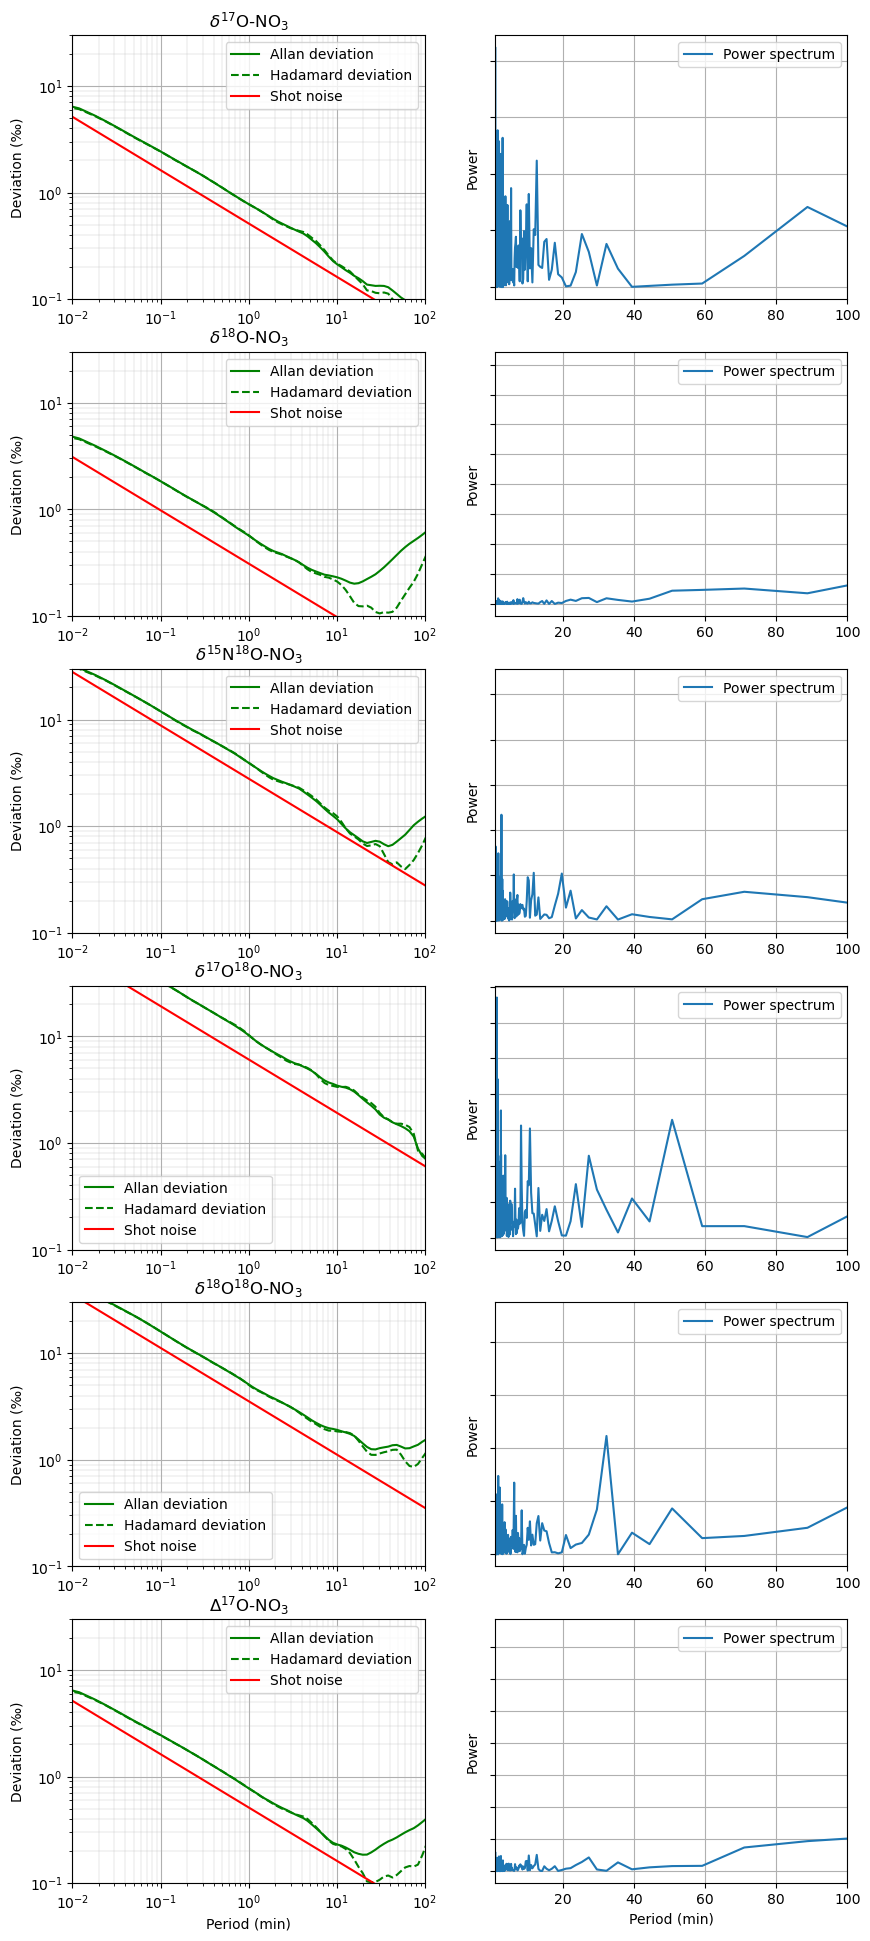

In [100]:
# plots
if plots:

    isotopelist = [col.split('_')[-1] for col in columns]
    fig,axes = plt.subplots(len(isotopelist),2,figsize=[10,4*len(isotopelist)])


    for j in range(len(isotopelist)):

        isotope = isotopelist[j]
        atau=save_adata['atau_'+isotope]
        adev=save_adata['adev_'+isotope]
        htau=save_hdata['htau_'+isotope]
        hdev=save_hdata['hdev_'+isotope]
        n_eff=save_adata['mean_n_eff_'+isotope][0]
        
        freq = save_spectrum['freq_'+isotope]
        power = save_spectrum['power_'+isotope]
        
        ax=axes[j,0] 

    #   plots allan dev
        ax.loglog(atau/60,adev, c='g',label='Allan deviation')
        #   plots h dev
        ax.loglog(htau/60,hdev, c='g',ls='--',label='Hadamard deviation')
    #   plots shot noise 
        ax.loglog(atau/60,1000*(atau*n_eff/(60*scan_duration))**-0.5, c='r',label='Shot noise')

        axes[-1,0].set_xlabel('Period (min)')
        ax.set_ylabel('Deviation (‰)')
        ax.grid(True, which='minor',lw=0.2)
        ax.grid(True, which='major')
        if isotope.startswith('D'):
            ax.set_title('$\Delta^{'+isotope[1:3]+'}$'+isotope[3]+'-'+expt[0:2]+'$_'+expt[2]+'$')
        elif len(isotope)==3:
            ax.set_title('$\delta^{'+isotope[0:2]+'}$'+isotope[2]+'-'+expt[0:2]+'$_'+expt[2]+'$')
        elif len(isotope)==6:
            ax.set_title('$\delta^{'+isotope[0:2]+'}$'+isotope[2]+'$^{'+isotope[3:5]+'}$'+isotope[5]+'-'+expt[0:2]+'$_'+expt[2]+'$')

        ax.set_ylim([0.1,30])
        ax.set_xlim([1e-2,1e2])
        ax.legend()
        
        ax=axes[j,1]
        
        # Plot the power spectrum
        ax.plot(1/freq, power, label='Power spectrum')  # Plot only positive frequencies
        ax.set_xlim([1,100])
        axes[-1,1].set_xlabel('Period (min)')
        ax.set_ylabel('Power')
        ax.set_yticklabels([])
        ax.grid(True)
        ax.legend()
        # ax.set_xscale('log')
